## 20. 가치 기반 알고리즘

### 20.2. DQN

In [4]:
import StatsBase as SB
import ReinforcementLearning as RL
import ProgressMeter as PM
import Distributions as Dist
import IntervalSets as IS
using Random: MersenneTwister
import Flux, Zygote, Functors
import Optimisers as Opt
import Plots

경험 재현 버퍼

In [5]:
struct SARS{A}
    sta::Vector{Float32}    # state
    act::A                  # action
    rew::Float32            # reward
    done::Bool              # done
    sta2::Vector{Float32}   # next state
end

In [6]:
mutable struct ReplayBuffer{A}
    const buffer::Vector{SARS{A}}
    const size::Int64
    const n_keeps::Int64
    ptr::Int64  # pointer
    full::Bool
    ReplayBuffer(::Type{A}, size, n_keeps) where A = begin
        @assert n_keeps < size
        buffer = Vector{SARS{A}}(undef, size)
        new{A}(buffer, size, n_keeps, 0, false)
    end
end

In [7]:
Base.length(b::ReplayBuffer) = b.full ? b.size : b.ptr

function Base.push!(b::ReplayBuffer{A}, sta, act, rew, done, sta2) where A
    if b.ptr == b.size
        b.full = true
        b.ptr = b.n_keeps + 1
    else
        b.ptr += 1
    end
    isa(act, AbstractArray) && (act = vec(act))
    b.buffer[b.ptr] = SARS(sta, A(act), rew, done, sta2)
end

In [8]:
function sample_batch(b::ReplayBuffer{A}, n, rng) where A
    idx = SB.sample(rng, 1:length(b), n)
    xs = b.buffer[idx]
    sta = hcat(map(x -> x.sta, xs)...)
    act = map(x -> x.act, xs)
    act = A <: Vector ? hcat(act...) : act'
    rew = map(x -> x.rew, xs)'
    done = map(x -> x.done, xs)'
    sta2 = hcat(map(x -> x.sta2, xs)...)
    (;sta, act, rew, done, sta2)
end

sample_batch (generic function with 1 method)

하이퍼 파라미터

In [9]:
Base.@kwdef mutable struct QlearnCfg
    pi_lr::Float32 = 0.0001 
    q_lr::Float32 = 0.0001

    buffer_size::Int64 = 10000
    init_keep::Int64 = 1000
    batch_size::Int64 = 64

    start_steps::Int64 = 10000
    update_after::Int64 = 1000
    update_every::Int64 = 10 # = gradient steps

    gamma::Float32 = 0.99
    polyak::Float32 = 0.995
    max_grad_norm::Float32 = 1.0

    state_dim::Int64 = 0
    action_dim::Int64 = 0

    conti_action::Bool = false    
    action_limit::Float32 = 1.0              # for continuous action
    action_space::Base.OneTo = Base.OneTo(1) # for discrete action
end

QlearnCfg

In [10]:
mutable struct Decay
    const start::Float32
    const decay::Float32
    const min::Float32
    curr::Float32
    Decay(start, decay, min) = new(start, decay, min, start)
end
reset!(d::Decay) = d.curr = d.start
decay!(d::Decay) = d.curr = max(d.min, d.curr * d.decay)

decay! (generic function with 1 method)

In [11]:
Base.@kwdef mutable struct Dqn
    eps::Decay = Decay(0.99, 0.9999, 0.1)
end
reset_exploration!(x::Dqn) = reset!(x.eps)
decay_exploration!(x::Dqn) = decay!(x.eps)

decay_exploration! (generic function with 1 method)

모델 정의

In [12]:
mutable struct ActorCritic{A,C}
    actor::A
    critic::C   # Q
end
Functors.@functor ActorCritic

In [13]:
mutable struct QlearnModel{A,C,PO,QO,Algo}
    main::ActorCritic{A,C}
    target::ActorCritic{A,C}
    pi_opt::PO
    q_opt::QO
    cfg::QlearnCfg
    algo::Algo
    rng::MersenneTwister
end

In [14]:
init(rng) = Flux.glorot_uniform(rng)

function get_network(cfg, ::Dqn, rng)
    critic = Flux.Chain(
        Flux.Dense(cfg.state_dim => 128, Flux.relu; init = init(rng)),
        Flux.Dense(128 => 128, Flux.relu; init = init(rng)),
        Flux.Dense(128 => cfg.action_dim; init = init(rng))
    )
    ActorCritic(Flux.Chain(), critic)
end

get_network (generic function with 1 method)

In [15]:
function QlearnModel(cfg, algo, rng)
    main = get_network(cfg, algo, rng)
    target = deepcopy(main)
    pi_opt = Opt.setup(Opt.Adam(cfg.pi_lr), main.actor)
    q_opt = Opt.setup(Opt.Adam(cfg.q_lr), main.critic)
    reset_exploration!(algo)
    QlearnModel(main, target, pi_opt, q_opt, cfg, algo, rng)
end

QlearnModel

전체 실행 함수

In [16]:
function run(model, env, buffer, tot_steps)
    train_rewards, test_rewards = Float32[], Float32[]
    cfg = model.cfg
    train_rew = 0.f0
    RL.reset!(env)
    PM.@showprogress 60 for t in 1:tot_steps
        state = copy(RL.state(env))
        if t > cfg.start_steps
            action = get_action(model, state, true, model.algo)
        else
            action = rand(model.rng, RL.action_space(env))
            if cfg.conti_action && isa(action, Number)
                action = [action]
            end
        end
        action_ = length(action) == 1 ? action[1] : action
        env(action_)
        rew = RL.reward(env)
        done = RL.is_terminated(env)
        push!(buffer, state, action, rew, done, copy(RL.state(env)))
        train_rew += rew

        if done
            push!(train_rewards, train_rew)
            train_rew = 0.f0

            test_rew = run_test_mode(model, env)
            push!(test_rewards, test_rew)

            RL.reset!(env)
        end
        
        if t >= cfg.update_after && t % cfg.update_every == 0
            train(model, buffer)
        end

        decay_exploration!(model.algo)
    end
    println()
    train_rewards, test_rewards
end

run (generic function with 1 method)

In [17]:
function run_test_mode(model, env)
    RL.reset!(env)
    rew_sum = 0.f0
    while true
        action = get_action(model, RL.state(env), false, model.algo)
        action = length(action) == 1 ? action[1] : action
        env(action)
        rew_sum += RL.reward(env)
        RL.is_terminated(env) && break
    end
    rew_sum
end

run_test_mode (generic function with 1 method)

행동 선택 함수

In [18]:
function get_action(model, state, train_mode, dqn::Dqn)
    if train_mode && rand(model.rng) < dqn.eps.curr
        rand(model.rng, model.cfg.action_space)
    else
        q = model.main.critic(state)
        findmax(q)[2]
    end
end

get_action (generic function with 1 method)

모델 훈련 함수

In [19]:
function train(model, buffer)
    cfg = model.cfg
    main = model.main
    batch = sample_batch(buffer, cfg.batch_size, model.rng)
    for _ in 1:cfg.update_every # = gradient steps
        critic_loss_fn = get_critic_loss_fn(model, batch, model.algo)
        grad = Zygote.gradient(critic_loss_fn, main.critic)[1]
        grad = clip_grad_norm(grad, cfg.max_grad_norm)
        model.q_opt, main.critic = Opt.update(model.q_opt, main.critic, grad)
        
        actor_loss_fn = get_actor_loss_fn(model, batch, model.algo)
        grad = Zygote.gradient(actor_loss_fn, main.actor)[1]
        grad = clip_grad_norm(grad, cfg.max_grad_norm)
        model.pi_opt, main.actor = Opt.update(model.pi_opt, main.actor, grad)
        
        soft_update_target!(model.target, main, cfg.polyak)
    end
end

train (generic function with 1 method)

In [20]:
function clip_grad_norm(grad, max_norm)
    sumsqr = 0.f0
    sqr = g -> isnothing(g) ? nothing : (sumsqr += sum(g .* g))
    _ = Functors.fmap(sqr, grad)
    norm = sqrt(sumsqr)
    if norm > max_norm
        f = g -> isnothing(g) ? nothing : g .* (max_norm / norm)
        return Functors.fmap(f, grad)
    end
    grad
end

clip_grad_norm (generic function with 1 method)

In [21]:
function soft_update_target!(target, main, polyak)
    f = (t, p) -> isa(t, Function) ? t : t * polyak + p * (1 - polyak)
    new_target = Functors.fmap(f, target, main)
    Flux.loadmodel!(target, new_target)
end

soft_update_target! (generic function with 1 method)

손실 함수 반환 함수

In [22]:
function get_critic_loss_fn(model, batch, ::Dqn)
    next_q_values = maximum(model.target.critic(batch.sta2), dims=1)
    next_q_values[batch.done] .= 0.f0
    targetQ = batch.rew .+ model.cfg.gamma .* next_q_values
    act_idx = CartesianIndex.(batch.act', 1:length(batch.act))

    critic -> begin
        action_values = critic(batch.sta)[act_idx]'
        Flux.Losses.mse(action_values, targetQ)
    end
end

get_critic_loss_fn (generic function with 1 method)

In [23]:
get_actor_loss_fn(_, _, ::Dqn) = _ -> 0.f0

get_actor_loss_fn (generic function with 1 method)

카트폴 결과

In [24]:
function plot_results(train_rew, test_rew, title)
    f = (cum, v) -> 0.95 * cum + 0.05 * v
    train_rew_avg = accumulate(f, train_rew; init = train_rew[1])
    test_rew_avg = accumulate(f, test_rew; init = test_rew[1])
    rew, label = [train_rew_avg, test_rew_avg], ["train" "test"]
    Plots.plot(rew, title=title, xlim=(0,length(train_rew)), label=label)
end

plot_results (generic function with 1 method)

In [25]:
function main(tot_steps, cfg, algo)
    conti_action = !isa(algo, Dqn)
    cfg.conti_action = conti_action
    rng = MersenneTwister(1)
    env = RL.CartPoleEnv(;T=Float32, continuous=conti_action, rng=rng)
    cfg.state_dim = length(RL.state_space(env))
    AS = RL.action_space(env)
    if conti_action
        cfg.action_dim = isa(AS, IS.Interval) ? 1 : length(AS)
        # 행동 공간이 0을 중심으로 대칭, 모든 차원 행동 범위 동일 가정
        cfg.action_limit = isa(AS, IS.Interval) ? AS.right : AS[1].right
    else
        cfg.action_dim = length(AS)
        cfg.action_space = AS
    end
    model = QlearnModel(cfg, algo, rng)
    actionTy = conti_action ? Vector{Float32} : Int64
    buffer = ReplayBuffer(actionTy, cfg.buffer_size, cfg.init_keep)
    run(model, env, buffer, tot_steps)    
end

main (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:17:04


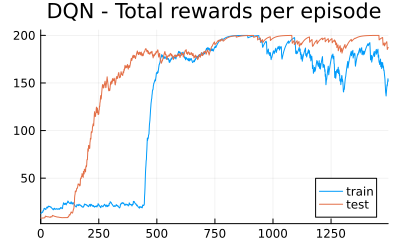

In [26]:
Plots.gr(size=(400, 250))
train_rew, test_rew = main(200000, QlearnCfg(), Dqn());
plot_results(train_rew, test_rew, "DQN - Total rewards per episode")

### 20.3. DDPG

코드 구현

In [27]:
Base.@kwdef mutable struct Ddpg
    noise::Decay = Decay(0.2, 0.9999, 0.1)
end
reset_exploration!(x::Ddpg) = reset!(x.noise)
decay_exploration!(x::Ddpg) = decay!(x.noise)

decay_exploration! (generic function with 2 methods)

In [28]:
function get_network(cfg, ::Ddpg, rng)
    actor = Flux.Chain(
        Flux.Dense(cfg.state_dim => 128, Flux.relu; init = init(rng)),
        Flux.Dense(128 => cfg.action_dim, tanh; init = init(rng)), 
        v -> v .* cfg.action_limit
    )
    st_ac_dim = cfg.state_dim + cfg.action_dim
    critic = Flux.Chain(
        Flux.Dense(st_ac_dim => 128, Flux.relu; init = init(rng)),
        Flux.Dense(128 => 128, Flux.relu; init = init(rng)),
        Flux.Dense(128 => 1; init = init(rng))
    )
    ActorCritic(actor, critic)
end

get_network (generic function with 2 methods)

In [29]:
function get_action(model, state, train_mode, ddpg::Ddpg)
    a = model.main.actor(state)
    if train_mode
        a .+= ddpg.noise.curr .* randn(model.rng, Float32, size(a))
    end
    cfg = model.cfg
    map(v -> clamp(v, -cfg.action_limit, cfg.action_limit), a)
end

get_action (generic function with 2 methods)

In [30]:
function get_critic_loss_fn(model, batch, ::Ddpg)
    next_actions = model.target.actor(batch.sta2)
    next_q_values = model.target.critic(vcat(batch.sta2, next_actions))
    next_q_values[batch.done] .= 0.f0
    targetQ = batch.rew .+ model.cfg.gamma .* next_q_values
    
    critic -> begin
        action_values = critic(vcat(batch.sta, batch.act))
        Flux.Losses.mse(action_values, targetQ)
    end
end

get_critic_loss_fn (generic function with 2 methods)

In [31]:
function get_actor_loss_fn(model, batch, ::Ddpg)
    actor -> -SB.mean(model.main.critic(vcat(batch.sta, actor(batch.sta))))
end

get_actor_loss_fn (generic function with 2 methods)

카트폴 결과

Progress: 100%|█████████████████████████████████████████| Time: 0:28:27


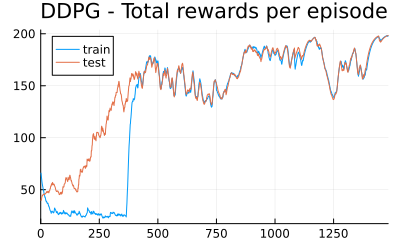

In [32]:
train_rew, test_rew = main(200000, QlearnCfg(), Ddpg());
plot_results(train_rew, test_rew, "DDPG - Total rewards per episode")

### 20.4. SAC

코드 구현

In [33]:
Base.@kwdef mutable struct Sac
    alpha::Decay = Decay(0.2, 0.9999, 0.1)
    min_std::Float32 = 0.0f0
    max_std::Float32 = 1.0f0
end
reset_exploration!(x::Sac) = reset!(x.alpha)
decay_exploration!(x::Sac) = decay!(x.alpha)

decay_exploration! (generic function with 3 methods)

In [34]:
mutable struct DoubleQ{Q}
    q1::Q
    q2::Q
end
Functors.@functor DoubleQ

In [35]:
function get_network(cfg, ::Sac, rng)
    actor = Flux.Chain(
        Flux.Dense(cfg.state_dim => 128, Flux.relu; init = init(rng)),
        Flux.Dense(128 => cfg.action_dim * 2; init = init(rng)) # mu, logstd
    )
    st_ac_dim = cfg.state_dim + cfg.action_dim
    q1 = Flux.Chain(
        Flux.Dense(st_ac_dim => 128, Flux.relu; init = init(rng)),
        Flux.Dense(128 => 128, Flux.relu; init = init(rng)),
        Flux.Dense(128 => 1; init = init(rng))
    )
    q2 = Flux.Chain(
        Flux.Dense(st_ac_dim => 128, Flux.relu; init = init(rng)),
        Flux.Dense(128 => 128, Flux.relu; init = init(rng)),
        Flux.Dense(128 => 1; init = init(rng))
    )
    ActorCritic(actor, DoubleQ(q1, q2))
end

get_network (generic function with 3 methods)

In [36]:
function sac_actor_forward(actor, state, cfg, sac, rng, 
    train_mode=true, with_logp=true)
    actor_out = actor(state)
    mu = actor_out[1:cfg.action_dim, :]
    logstd = actor_out[cfg.action_dim+1:end, :]
    std = clamp.(exp.(logstd), sac.min_std, sac.max_std)
    actions = mu
    if train_mode
        actions = actions .+ randn(rng, Float32, size(mu)) .* std
    end
    logp = 0.f0
    if with_logp
        logp = sum(Dist.normlogpdf.(mu, std, actions); dims=1)
        correction = 2.f0 .* (log(2.f0) .- actions .- Flux.softplus(-2.f0 .* actions))
        logp = logp .- sum(correction; dims=1)
    end
    actions = tanh.(actions) .* cfg.action_limit
    actions, logp
end

sac_actor_forward (generic function with 3 methods)

In [37]:
function get_action(model, state, train_mode, sac::Sac)
    actions, _ = sac_actor_forward(model.main.actor, 
        state, model.cfg, sac, model.rng, train_mode, false)
    actions
end

get_action (generic function with 3 methods)

In [38]:
function get_critic_loss_fn(model, batch, sac::Sac)
    next_actions, logp_a2 = sac_actor_forward(model.main.actor, 
        batch.sta2, model.cfg, sac, model.rng)
    
    q1_targ = model.target.critic.q1(vcat(batch.sta2, next_actions))
    q2_targ = model.target.critic.q2(vcat(batch.sta2, next_actions))
    q_targ = min.(q1_targ, q2_targ)

    next_q_values = q_targ .- sac.alpha.curr .* logp_a2
    next_q_values[batch.done] .= 0.f0
    tgtQ = batch.rew .+ model.cfg.gamma .* next_q_values
    
    critic -> begin
        q1 = critic.q1(vcat(batch.sta, batch.act))
        q2 = critic.q2(vcat(batch.sta, batch.act))
        Flux.Losses.mse(q1, tgtQ) + Flux.Losses.mse(q2, tgtQ)
    end
end

get_critic_loss_fn (generic function with 3 methods)

In [39]:
function get_actor_loss_fn(model, batch, sac::Sac)
    sta = batch.sta
    cfg = model.cfg
    actor -> begin
        actions, logp = 
            sac_actor_forward(actor, sta, cfg, sac, model.rng)
        q1 = model.main.critic.q1(vcat(sta, actions))
        q2 = model.main.critic.q2(vcat(sta, actions))
        q = min.(q1, q2)
        -SB.mean(q .- sac.alpha.curr .* logp)
    end
end

get_actor_loss_fn (generic function with 3 methods)

카트폴 결과

Progress: 100%|█████████████████████████████████████████| Time: 0:54:13


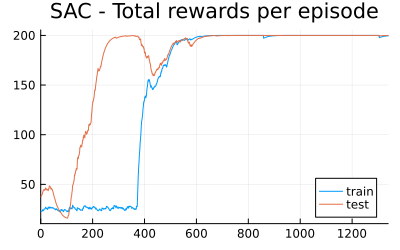

In [40]:
train_rew, test_rew = main(200000, QlearnCfg(), Sac());
plot_results(train_rew, test_rew, "SAC - Total rewards per episode")